In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres
from scipy.io import loadmat

# 0 - Original motivation for the NMF algorithm: dimensionality reduction

As an introduction, we will first use NMF as a dimensionality reduction tool, which corresponds to the orginal motivation of the Multiplicative Update (MU) algorithm. Specifically, in this whole part, we will try to extract features from a data set composed of pictures. In contrast to BSS, we will not look for "true" features at the origin of the data set, but we will merely perform dimensionality reduction.

## 0 - 1) Dataset

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. 

**Goal**

The goal of this part is to evaluate qualitatively the relevance of the features found by NMF. To do so, we above load the dataset and implement a function to plot the faces.

In [2]:
# Please modify working_dir if required
Working_directory="./"


x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

X = data


def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=int(np.ceil(len(indeces)/ncol))
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## 0 - 2) MU algorithm

Here you will implement the MU algorithm and launch it to reduce the dimensionality of the dataset. In this context, the basis images are in the matrix $W$ (it is the equivalent of the A mixing matrix in BSS) and the scores (or coefficients) to test the performance in $H$ (it is the equivalent of the sources S in BSS).

**Question**

1) Complete below the codes where XXXXXXX are written.

2) Plot the basis images found by NMF. What can you say ?

3) Should the error converge to 0 ? Why ?

$\hookrightarrow$ Error needs not to converge to 0 as the minimal reconstruction error can be strictly positive.

In [3]:
def multiplicativeUpdate(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1, W=None):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    if W is None:
        W = np.random.rand(d, r)
    H = np.random.rand(r, N)
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # Multiplicative method      
        W = np.maximum(eps, W * (X @ H.T) / (W @ H @ H.T))
        H = np.maximum(eps, H * (W.T @ X) / (W.T @ W @ H))
        
        
        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     

        delta = np.linalg.norm(diff,'fro') / np.linalg.norm(X,'fro') 
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', np.linalg.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

In [6]:
X.shape

((2414, 1024), 1024)

Iteration NNMF number  1  out of  300 , delta =  0.5364897579799421 , error (norm delta):  309.3530238954215
Iteration NNMF number  100  out of  300 , delta =  0.1904850640127199 , error (norm delta):  109.83831412015687
Iteration NNMF number  200  out of  300 , delta =  0.16654443752154077 , error (norm delta):  96.03356745195676
Iteration NNMF number  300  out of  300 , delta =  0.159451189718547 , error (norm delta):  91.94342849877711
Maximum number of iterations reached ! delta =  0.159451189718547


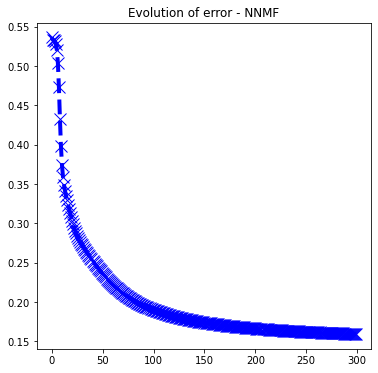

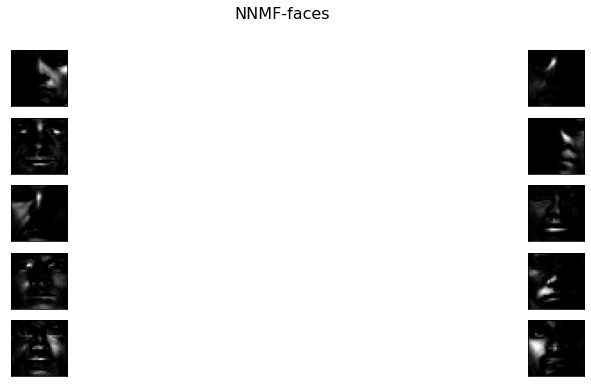

In [21]:
# Launch the MU algorithm
Ncomponents=100
W,H = multiplicativeUpdate(X.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(W.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# I - NMF for BSS
We now come back to the BSS case, in which there exist true underlying factors at the orgin of the dataset.

## I - 1) Data generation and manipulation

In the remaining of this practical session, we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used in the hyperspectral unmixing study. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 sources.

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

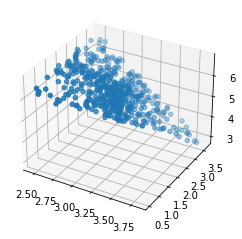

In [22]:
n = 3
m = 3
t = 500

A_toy = 10*np.random.rand(m,n)

S_toy = np.random.rand(n,t)
S_toy = S_toy/np.sum(S_toy,axis=0)

X_toy = A_toy.dot(S_toy)




fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])

**2) Real hyperspectral data set** 

Here, to matrices can be found :
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (aka concentration of each material). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

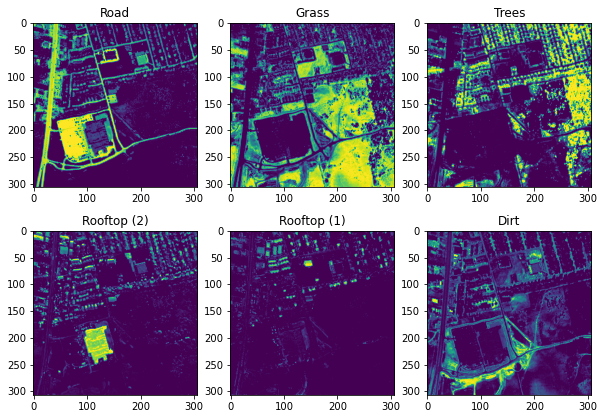

In [25]:
data = sci.loadmat('Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure(figsize=(10,7))
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
names = ['Road','Grass','Trees','Rooftop (2)','Rooftop (1)','Dirt']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])


- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

$\hookrightarrow$ Yes because pure pixel exists i.e. their exist regions on the image with only road, tree, grass etc...

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your answer to the to explain how the following code finds the columns of the mixing matrix A. 

$\hookrightarrow$ For a given source and a given channel, we select the pure pixels for this source and take their mean intensity as the value for this channel.

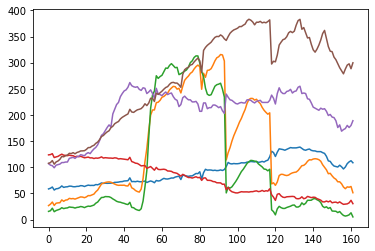

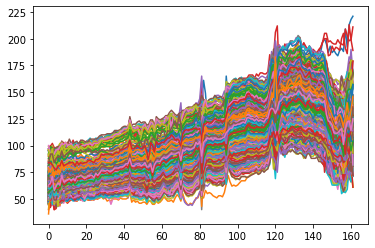

In [28]:
endmembers = np.zeros((162,6))

for ii in range(6):
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

ind = np.where(abundances[0] > 0.999)[0]
allPP = X[:,ind]
plt.figure(),plt.plot(allPP);

# II - Near separable NMF

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

2) Implement the SPA algorithm

In [63]:
def simpleSPA(Xin,r,optDisp=False): # TO DO. 

    R = Xin.copy()    

    K = np.zeros(r)

    for ii in range(r):
        p = np.argmax(np.linalg.norm(R, axis=0))
        K[ii] = p
        rp = R[:,p]
        
        R = (np.eye(len(Xin)) - rp[:,None] @ rp[None] / np.sum(rp**2)) @ R
        
        if optDisp:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(R[0,:],R[1,:],R[2,:])
        
    print('Max residual %s'%np.max(R))
    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA. 

How many sources can you at most extract ? Why ?

$\hookrightarrow$ We can extract at most $d$ sources (here $d=3$) because this is the dimension of the space the cone of data live in. Trying to extract more sources will lead unstable irrelevant results.

Max residual 5.551115123125783e-16


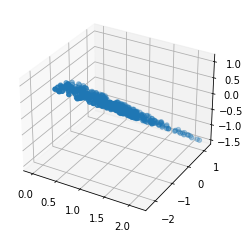

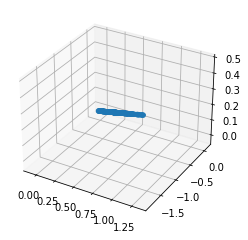

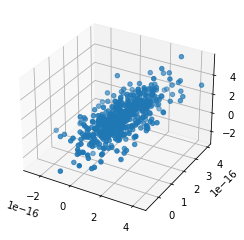

In [64]:
K_SPA = simpleSPA(X_toy,3,optDisp = True)

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms. 

Use it to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

$\hookrightarrow$ Endmembers look very noisy.

In [65]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));
    
    return An



        
def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W0 = norm_col(W0)
    W = norm_col(W)
    
    costmat = -W0.T@W; # Avec Munkres, il faut bien un -

    
    m = Munkres()
    Jperm = m.compute(costmat.tolist())
    #print(Jperm)
    
    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])
    
    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]
        
    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W,indPerm = correctPerm(W0,W);
    
    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;
    
    return np.mean(np.diag(diff));

Max residual 163.71498109412852
Critere SPA : 0.9149174369799745


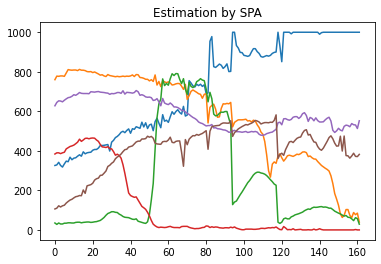

In [44]:
# CORRECTION
K_SPA = simpleSPA(X,6)

A_SPA = X[:,K_SPA]

Ac_SPA,indPerm = correctPerm(endmembers, A_SPA)

plt.figure(),plt.plot(Ac_SPA)
plt.title('Estimation by SPA')

print('Critere SPA : %s'%evalCriterion(endmembers,A_SPA))

# III - PLAIN NMF

In this part, we will perform plain NMF. To do that, you will re-use the MU algorithm that you implemented above.

    1) Launch the MU algorithm on the real dataset
    2) Can you find a better initialization than the random one ? Try it !
    
  $\hookrightarrow$ We us SPA result as initialization.

Iteration NNMF number  1  out of  300 , delta =  0.27758610995753635 , error (norm delta):  220568.20903800585
Iteration NNMF number  100  out of  300 , delta =  0.047690268155674335 , error (norm delta):  37894.39261657748
Iteration NNMF number  200  out of  300 , delta =  0.04068131827504663 , error (norm delta):  32325.12431765688
Iteration NNMF number  300  out of  300 , delta =  0.03973449176856363 , error (norm delta):  31572.781821713495
Maximum number of iterations reached ! delta =  0.03973449176856363


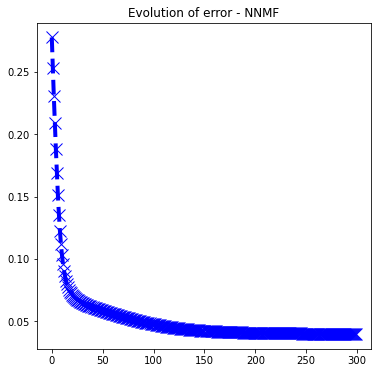

In [48]:
A_MU,S_MU = multiplicativeUpdate(X,r=6,N_Iter=300,tolerance=1e-3,plot_evolution=1,W=A_SPA)

Critere MU : 0.9590465183100835


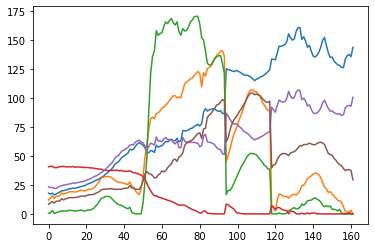

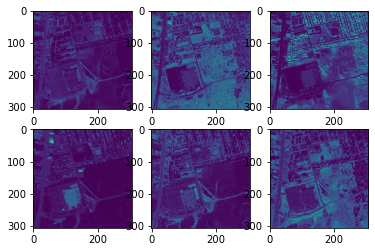

In [49]:
Ac,indPerm = correctPerm(endmembers, A_MU)

plt.figure(),plt.plot(Ac)

Sc = S_MU[indPerm,:]

print('Critere MU : %s'%evalCriterion(endmembers,A_MU))

plt.figure()
for ii in range(6): #TO DO
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(Sc[ii,:].reshape(nCol,nRow))

**THE REMAINING OF THIS PART IS OPTIONAL**

**1)** Implement the proximal operator of the nonnegativity constraint.

**2)** Implement the PALM algorithm to solve the plain NMF problem.

**3)** Launch the PALM algorithm on the real hyperspectral dataset. 

In [57]:
def prox_positive(S): # TO DO : coder le prox
    return np.maximum(0,S)


def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO
    if np.all(Ainit == None):
        A_est = np.random.rand(np.shape(X)[0],n)
    else:
        A_est = Ainit.copy()

    if np.all(Sinit == None):
        S_est = np.random.rand(n,np.shape(X)[1])
    else:
        S_est = Sinit.copy()


    for it in range(nbIt):
        # S update
        if np.mod(it,100)==0:
            print(it)
        gamma = 1 / np.linalg.norm(A_est.T @ A_est, ord=2)
        S_est = S_est - gamma * A_est.T @ (A_est @ S_est - X)


        S_est = prox_positive(S_est)

        # A update
        eta = 1 / np.linalg.norm(S_est @ S_est.T, ord=2)
        A_est =  A_est - eta*(A_est @ S_est - X) @ S_est.T


        A_est = prox_positive(A_est)

    return A_est,S_est

0
100
200
300
400
500
600
700
800
900
Critere PALM : 0.9174244850349194


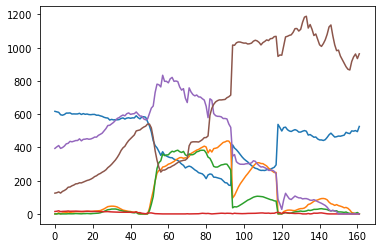

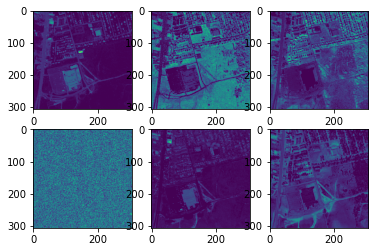

In [58]:
A_est,S_est = PALM(X,n=6,nbIt = 1000,Ainit=A_SPA,Sinit=None) 

Ac,indPerm = correctPerm(endmembers, A_est)

plt.figure(),plt.plot(Ac)

Sc = S_est[indPerm,:]

print('Critere PALM : %s'%evalCriterion(endmembers,A_est))

plt.figure()
for ii in range(6): #TO DO
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(Sc[ii,:].reshape(nCol,nRow))

# IV - MINIMUM VOLUME NMF

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classe, the code is fully given below.

In [59]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  6 10:45:53 2021

@author: ckervazo
"""
import numpy as np
import scipy.io as sci

def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex  

#       Delta = { x | x >= 0 and sum(x) <= 1 }, 

# that is, Y = argmin_z ||x-X||_2  such that z in S. 

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ****** 
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ****** 
# Y       : the projected matrix

# Code from the paper 
# P. De Handschutter, N. Gillis, A. Vandaele and X. Siebert, 
# "Near-Convex Archetypal Analysis", IEEE Signal Processing Letters 27 (1),
# pp. 81-85, 2020. 

    
    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1]) 
    
    Y = np.zeros(np.shape(X))
    
    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy
    
        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;
        
        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection
    
        min_sum=np.sum(x)-len(x)*mu_min
        
        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/np.float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1
                
                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)
                
                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind
                    
                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True
                    
                    
                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True
                    
                    
            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))
                
            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear
            
            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)
            
            Y[:,ii]=y
            
            
            
    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.  
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
    # Course, Kluwer Academic Publisher, 2004. 
    
    # This code solves: 
    
    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter) 
    
    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500). 
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above. 
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A))); 
    
    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)
        
    
    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6
    
    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W
        
        # FGM Coefficients  
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2); 
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1)); 
        
        # Projected gradient step from Y
        W = Y - (Y@A-C) / L 
        
        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )
            
        
        # Linear combination of iterates
        Y = W + beta*(W-Wp)
        
        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)
        
        
        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out. 
        
        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W
            
        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))
        
        eps = np.sqrt(np.sum((W-Wp)**2))
        
        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)
    
     #           min_{H >= 0} ||X-WH||_F^2
     
     # using a fast gradient method; 
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
     # Course, Kluwer Academic Publisher, 2004. 
     
     # Input / Output; see nnls_input_output.m  
     
     # + options.proj allows to use a contraints on the columns or rows of H so 
     #   that the entries in each column/row sum to at most one 
     #   options.proj = 0: no projection (default). 
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1} 
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1} 
          
     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM
    
     # Code modified from https://sites.google.com/site/nicolasgillis/code
    

   
    
    # If no initial matrices are provided, H is initialized as follows: 
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))

    
    # Hessian and Lipschitz constant 
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term 
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0
    
    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0) 
        K = np.where(np.sum(H,axis=0) > 1.)[0] 
        H[:,K] = simplexProx( H[:,K] ) 
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T 
    
    
    
    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1  
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H; 
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L
        
        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1} 
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )  
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T
        
        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')
        
        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1; 
      


    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X): # A TESTER
    # Normalization depending on the NMF model 
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1
                      
        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g. 
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T
        
        H = Hn 
        
    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )
        
    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2

    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)
    
    WtW = W.T@W;
    WtX = W.T@X;
    
    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)
    
    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK
    
    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))
    
    e[0] =  err1[0] + lamb * err2[0] # OK

    
    
    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0
    
    
    # Main loop 
    
    for ii in range(1,maxiter):
        if np.mod(ii,100) == 0:
            print(ii)
            
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T
        
        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt
        
        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H
        

        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)

        
        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))
        
        e[ii] = err1[ii] + lamb * err2[ii]
        
        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05
                
                
    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [61]:
[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,W=A_SPA,H=S_est,r=6,lamb=1.,maxiter=1000,target=0.05,model=1)

C:\Users\yugos\AppData\Local\Temp/ipykernel_9980/599969443.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mu=(np.sum(x)-1.)/np.float(len(x))


100
200
300
400
500
600
700
800
900


**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

Critere Min Vol : 0.8871514823119756


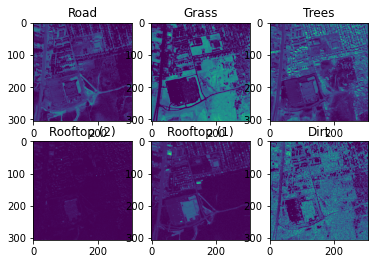

In [62]:
W3c,indPerm = correctPerm(endmembers, W3_t)


plt.figure()
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[indPerm[ii],:].reshape(nCol,nRow))
    
    plt.title(names[ii])


print('Critere Min Vol : %s'%evalCriterion(endmembers,W3_t))


$\hookrightarrow$
* **SPA**: Very fast greedy algorithm. Very poor results but fast initiliazer for other algorithms.
* **MU**: Easily implemented, does not require hyperparameter tuning.
* **PALM**: More costly algorithm. Poor results in this example.
* **MinVol NMF**: More costly algorithm Best results in this example.
